<a href="https://colab.research.google.com/github/RishitSingh10/Multiclass-Image-Classification/blob/main/project_1_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Description:
## Problem:
Multiclass image classification of food images.
## Data:
Food 101 dataset.
## Goal:
The aim of this project is to build a transfer learning model using EfficientNetB0 which beats the baseline [DeepFood](https://arxiv.org/abs/1606.05675), a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

## Check GPU

GPUs with computing cabability score of 7.0 or more are suitable for **mixed precision training** (faster model training).

Colab offers Tesla T4 which is compatible.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ea856ec7-bb33-45fe-513a-2b7a197ab266)


In [2]:
import tensorflow as tf
import numpy as np

tf.__version__

'2.13.0'

## Get Helper Functions

In [82]:
# Download helper functions script
!wget https://raw.githubusercontent.com/RishitSingh10/Multiclass-Image-Classification/main/helper_functions.py

--2023-09-16 10:57:40--  https://raw.githubusercontent.com/RishitSingh10/Multiclass-Image-Classification/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11043 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.78K  --.-KB/s    in 0s      

2023-09-16 10:57:40 (92.9 MB/s) - ‘helper_functions.py’ saved [11043/11043]



In [83]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

In [5]:
# Get TenfsorFlow Datasets
import tensorflow_datasets as tfds

In [6]:
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target datset in the list of TFDS datasets

True


In [7]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files = False,
                                             as_supervised = True, # data gets returned in tuple format (data, label)
                                             with_info = True )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteIXGOVF/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteIXGOVF/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

We want to find:
* Class names
* The shape of our input data (image tensors)
* The data of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names

In [8]:
# Size of our dataset
len(train_data), len(test_data)

(75750, 25250)

In [9]:
# Features
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
len(class_names)

101

In [12]:
# Take one sample of the train data
train_one_sample = train_data.take(1)

In [13]:
# What does on sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
  


In [15]:
# What does an image tensor from TFDS's Food101 look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [16]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

(-0.5, 511.5, 511.5, -0.5)

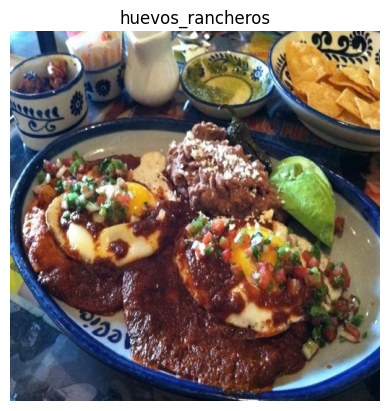

In [17]:
# Plot an image tensor
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

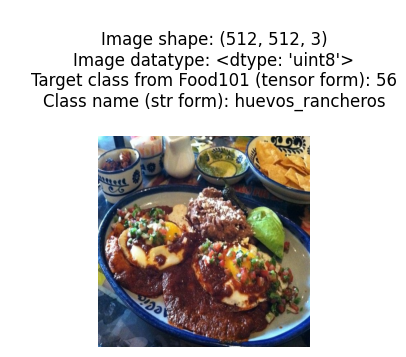

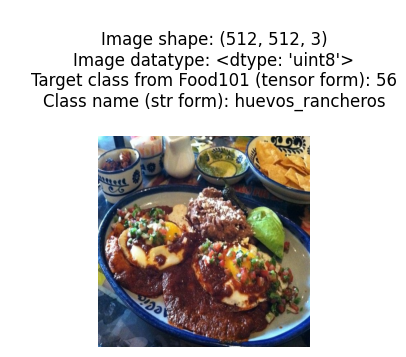

In [18]:
# Plotting multiple image tensors
for i in range(0,2):
  n_samples = train_data.take(1)

  for image, label in n_samples:

    plt.figure(figsize=(6,10))
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)
    plt.axis(False)

## Create preporcessing functions for our data:

Getting our data ready to feed it into a neural network.

What we know about our data:
* In 'uint8' datatype
* Comprised of all different size tensors (different size images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in 'float32' dtype (or for mixed precision 'float16' and 'float32')
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalised tensors generally perform better

In [19]:
def preprocess_img(image, label, img_shape=224):
  """
  Takes an image tensor and returns a resized image tensor with float32 datatype
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape

  return tf.cast(image, dtype = tf.float32), label # return (float32_image, label) tuple

In [20]:
# Preprocessa single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"""BEFORE
      image: {image[:2]}
      shape: {image.shape}
      dtype: {image.dtype}""")

print(f"""AFTER
      image: {preprocessed_img[:2]}
      shape: {preprocessed_img.shape}
      dtype: {preprocessed_img.dtype}""")

BEFORE
      image: [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]
      shape: (512, 512, 3)
      dtype: <dtype: 'uint8'>
AFTER
      image: [[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]
      shape: (224, 224, 3)
      dtype: <dtype: 'float32'>


(-0.5, 223.5, 223.5, -0.5)

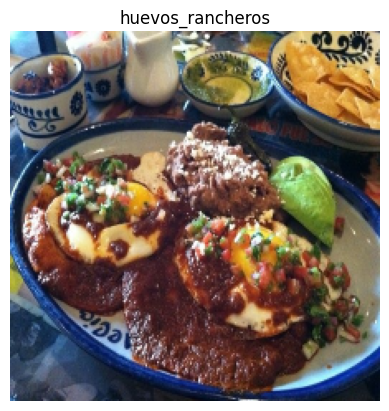

In [21]:
# Plotting the preprocessed image
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False)

## Batch & prepare datasets

Turning our data from 101,000 (train and test combined) image tensors and labels into batches of 32 image and label pairs.

To do this we're leveraging `tf.data` API

Reference: https://www.tensorflow.org/guide/data_performance

The order we're following:
`Original dataset -> map() -> shuffle() -> batch() -> prefetch() -> Prefetched dataset`

In [22]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data and turn it into batches and prefetch it
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

`(image, label)` with datatypes of `(tf.float32, tf.int64)`

What we're doing above in english:

> "Hey TensorFlow map this preprocessing function (`preprocess_img`) accross our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch"

## Create modeling callbacks

* TensorBoard callback to log training results (so we can visualise them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction  

In [ ]:
# tensorboard callback
from helper_functions import create_tensorboard_callback

# ModelCheckpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_accuracy',
                                                      mode='max',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training
Reference: https://www.tensorflow.org/guide/mixed_precision

Mixed precison utilizes a combination of float32 and float16 data types to speed up model performance.

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers

# Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create Functional model
inputs = layers.Input(shape = (224,224,3), name = 'input_layer')
x = base_model(inputs, training = False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(101)(x)
outputs = layers.Activation('softmax', dtype = tf.float32)(x) # output float32 activations
model = tf.keras.Model(inputs, outputs)

# Compiling the model
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 activation_1 (Activation)   (None, 101)               0         
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (

## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
activation_1 True float32 <Policy "float32">


* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with (store more tensors on the GPU memory)

In [ ]:
# Checking the layers in the base model and seeing what dtype policy they're using
for i, layer in enumerate(model.layers[1].layers):
  print(i, layer.name, layer.dtype, layer.dtype_policy)

0 input_2 float32 <Policy "float32">
1 rescaling_2 float32 <Policy "mixed_float16">
2 normalization_1 float32 <Policy "mixed_float16">
3 rescaling_3 float32 <Policy "mixed_float16">
4 stem_conv_pad float32 <Policy "mixed_float16">
5 stem_conv float32 <Policy "mixed_float16">
6 stem_bn float32 <Policy "mixed_float16">
7 stem_activation float32 <Policy "mixed_float16">
8 block1a_dwconv float32 <Policy "mixed_float16">
9 block1a_bn float32 <Policy "mixed_float16">
10 block1a_activation float32 <Policy "mixed_float16">
11 block1a_se_squeeze float32 <Policy "mixed_float16">
12 block1a_se_reshape float32 <Policy "mixed_float16">
13 block1a_se_reduce float32 <Policy "mixed_float16">
14 block1a_se_expand float32 <Policy "mixed_float16">
15 block1a_se_excite float32 <Policy "mixed_float16">
16 block1a_project_conv float32 <Policy "mixed_float16">
17 block1a_project_bn float32 <Policy "mixed_float16">
18 block2a_expand_conv float32 <Policy "mixed_float16">
19 block2a_expand_bn float32 <Policy "m

## Fit the feature extraction model

In [ ]:
# Fit the feature extraction model
history = model.fit(train_data,
                    epochs = 3,
                    steps_per_epoch = len(train_data),
                    validation_data = test_data,
                    validation_steps = int(0.15*len(test_data)),
                    callbacks = [create_tensorboard_callback(dir_name = 'training_logs',
                                                            experiment_name = 'feature_extract_model'),
                                 model_checkpoint])

Saving TensorBoard log files to: training_logs/feature_extract_model/20230909-131816
Epoch 1/3
2368/2368 [==============================] - 218s 85ms/step - loss: 1.7204 - accuracy: 0.5830 - val_loss: 1.1160 - val_accuracy: 0.7039
Epoch 2/3
2368/2368 [==============================] - 201s 82ms/step - loss: 1.1996 - accuracy: 0.6889 - val_loss: 1.0295 - val_accuracy: 0.7166
Epoch 3/3
2368/2368 [==============================] - 177s 74ms/step - loss: 1.0540 - accuracy: 0.7249 - val_loss: 0.9963 - val_accuracy: 0.7259


In [ ]:
# Evaluate model on whole dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 52s 66ms/step - loss: 0.9977 - accuracy: 0.7283


[0.9977330565452576, 0.7282772064208984]

Still below the DeepFood paper base line

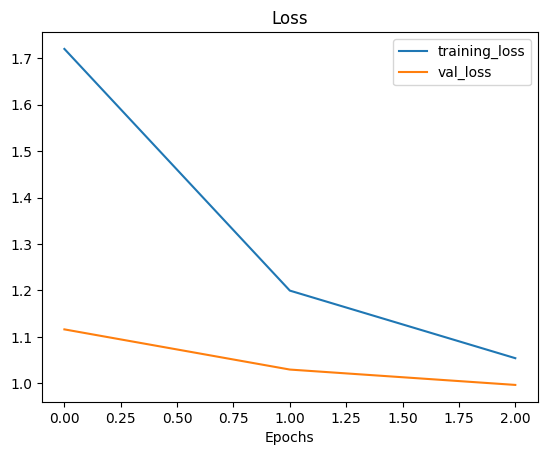

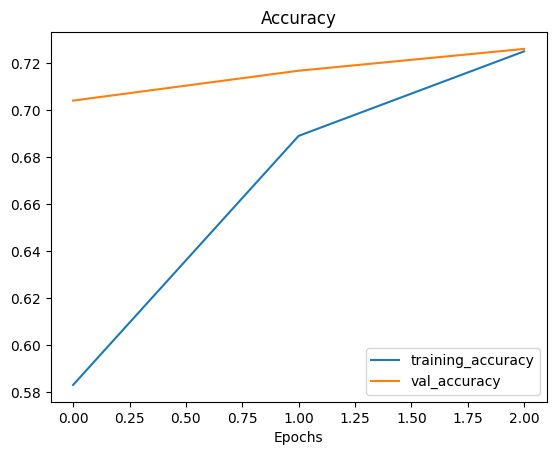

In [ ]:
# Plotting loss curves
plot_loss_curves(history)

## Saving the model

In [ ]:
# Saving the model locally
model.save('feature_extract_model')

In [ ]:
# Loading the saved model
loaded_model = tf.keras.models.load_model('feature_extract_model')

In [ ]:
# Checking loaded model performance
results_loaded_model = loaded_model.evaluate(test_data)
results_loaded_model

790/790 [==============================] - 57s 70ms/step - loss: 0.9977 - accuracy: 0.7283


[0.9977321028709412, 0.7282772064208984]

In [ ]:
# Comparing our loaded model results with model results prior to saving
import numpy as np
np.isclose(results_feature_extract_model, results_loaded_model)

array([ True,  True])

In [ ]:
## Saving model to Google Drive
import os
from google.colab import drive
drive.mount('/content/drive')

save_dir = "drive/MyDrive/food_vision_project/feature_extract_model/"
os.makedirs(save_dir)
model.save(save_dir)

Mounted at /content/drive


# Preparing our model's layers for fine tuning
Note that we've still not beaten the DeepFood paper

In [ ]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 activation_1 (Activation)   (None, 101)               0         
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (

In [ ]:
# Checking our base_model layers from loaded_model
for i, layer in enumerate(loaded_model.layers[1].layers):
  print(i, layer.name, layer.trainable)


0 input_2 True
1 rescaling_2 True
2 normalization_1 True
3 rescaling_3 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2b

In [ ]:
# unfreezing all the layers for fine tuning
for i, layer in enumerate(loaded_model.layers):
  layer.trainable = True
  print(i,layer.name, layer.trainable)

0 input_layer True
1 efficientnetb0 True
2 global_average_pooling2d_1 True
3 dense_1 True
4 activation_1 True


In [ ]:
# Recompiling the model
loaded_model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # lower the learining rate by 10x to avoid overfitting
              metrics=['accuracy'])

In [ ]:
for i, layer in enumerate(loaded_model.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 efficientnetb0 True
2 global_average_pooling2d_1 True
3 dense_1 True
4 activation_1 True


# Creating two more callbacks:
* Early Stopping
* Learning Rate Reduction

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                  patience = 3)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only = True,
                                                      monitor = "val_loss")

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_lr = 1e-7)

In [ ]:
# Start to fine-tune
fine_tune_epochs = 100
history_fine_tune = loaded_model.fit(train_data,
                                     epochs = fine_tune_epochs,
                                     steps_per_epoch = len(train_data),
                                     validation_data = test_data,
                                     validation_steps = int(.15*len(test_data)),
                                     callbacks = [create_tensorboard_callback(dir_name = 'training_logs',
                                                                              experiment_name = 'fine_tune_model'),
                                                  model_checkpoint,
                                                  early_stopping,
                                                  reduce_lr])

Saving TensorBoard log files to: training_logs/fine_tune_model/20230909-143926
Epoch 1/100
2368/2368 [==============================] - 509s 190ms/step - loss: 0.8692 - accuracy: 0.7663 - val_loss: 0.7862 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 425s 178ms/step - loss: 0.5377 - accuracy: 0.8513 - val_loss: 0.7406 - val_accuracy: 0.7969 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 375s 157ms/step - loss: 0.2973 - accuracy: 0.9141 - val_loss: 0.8257 - val_accuracy: 0.7844 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1607 - accuracy: 0.9526
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 374s 157ms/step - loss: 0.1607 - accuracy: 0.9526 - val_loss: 0.9835 - val_accuracy: 0.7810 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 376s 158ms/step - loss: 0.0329 - acc

In [ ]:
# Evaluate model on whole dataset
results_fine_tune_model = loaded_model.evaluate(test_data)
results_fine_tune_model

790/790 [==============================] - 53s 66ms/step - loss: 1.0256 - accuracy: 0.8018


[1.025559425354004, 0.8017821907997131]

In [ ]:
# Saving our fine tuned model on drive
loaded_model.save("/content/drive/MyDrive/food_vision_project/fine_tuned_model")

# Viewing training results on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot

2023-09-09 15:16:05.355025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   NGS-BMP-PRN



New experiment created. View your TensorBoard at: https://tensorboard.dev/expe

View TensorBoard results here: https://tensorboard.dev/experiment/lAgJGF5QRQ2zlWwhaDpSZg/

By observing the training and testing loss curves for the fine tuned model, we can clearly see our model is overfitting on the training data. To tackle this issue we can either:
* Unfreeze less layers and finetune them.
* A different iteration of EfficientNet (e.g. EfficientNetB4 instead of EfficientNetB0).

# Evaluating our trained model

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
file_path = "/content/drive/MyDrive/food_vision_project/fine_tuned_model_efficientnetb0.zip"
import zipfile
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall()
zip_ref.close()

In [30]:
loaded_model = tf.keras.models.load_model('fine_tuned_model')

In [31]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 63s 68ms/step - loss: 1.0256 - accuracy: 0.8018


[1.025560736656189, 0.8017821907997131]

In [32]:
# Making predictions on the test dataset
pred_probs = loaded_model.predict(test_data)
pred_classes = pred_probs.argmax(axis=1)

790/790 [==============================] - 54s 66ms/step


In [33]:
tf.argmax(pred_probs[0])

<tf.Tensor: shape=(), dtype=int64, numpy=29>

In [35]:
class_names[29]

'cup_cakes'

In [36]:
pred_classes

array([29, 81, 91, ..., 46, 31, 21])

In [37]:
pred_probs.shape

(25250, 101)

In [38]:
# As we can see the labels in our test dataset our in batches of 32
for _, label in test_data.take(1):
  print(label)

tf.Tensor(
[ 29  81  91  53  97  97  10  31   3 100   4  32  32   3   8  85  84  60
  29  80  32  78  17   1  40  40  99   1  71  42   6  44], shape=(32,), dtype=int64)


In [39]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch().as_numpy_iterator():
  y_labels.append(labels)
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [40]:
# To check that our model's predictions and our test labels are in the same order
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_labels, pred_classes)
accuracy

0.8017821782178218

## Making a confusion matrix

In [85]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make somde changes in our make_confusion_matrix function to ensure x axis labels print vertically

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changes (plot x-labels vertically) ###
  plt.xticks(rotation=90, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [86]:
make_confusion_matrix(y_labels,
                      pred_classes,
                      class_names,
                      figsize=(100,100),
                      text_size=10,
                      savefig=True)

## Classification Report

In [42]:
from sklearn.metrics import classification_report

# Getting classification report as a dictionary
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.5659722222222222,
  'recall': 0.652,
  'f1-score': 0.6059479553903346,
  'support': 250},
 '1': {'precision': 0.8767772511848341,
  'recall': 0.74,
  'f1-score': 0.8026030368763557,
  'support': 250},
 '2': {'precision': 0.800711743772242,
  'recall': 0.9,
  'f1-score': 0.8474576271186439,
  'support': 250},
 '3': {'precision': 0.8038461538461539,
  'recall': 0.836,
  'f1-score': 0.8196078431372548,
  'support': 250},
 '4': {'precision': 0.8099547511312217,
  'recall': 0.716,
  'f1-score': 0.7600849256900212,
  'support': 250},
 '5': {'precision': 0.7777777777777778,
  'recall': 0.7,
  'f1-score': 0.7368421052631577,
  'support': 250},
 '6': {'precision': 0.8249027237354085,
  'recall': 0.848,
  'f1-score': 0.8362919132149901,
  'support': 250},
 '7': {'precision': 0.8745247148288974,
  'recall': 0.92,
  'f1-score': 0.8966861598440545,
  'support': 250},
 '8': {'precision': 0.6182572614107884,
  'recall': 0.596,
  'f1-score': 0.6069246435845214,
  'support': 250},

In [46]:
# Turning classification report into a dataframe to help us visualize better

import pandas as pd
classification_report_df = pd.DataFrame(classification_report_dict).transpose()
classification_report_df.drop(['accuracy','macro avg','weighted avg'],inplace=True)
classification_report_df.reset_index(drop=True,inplace=True)

In [47]:
classification_report_df['class_names'] = class_names

In [71]:
# Comparing f1-scores for different calsses

f1_scores = classification_report_df[['class_names','f1-score']].sort_values(by='f1-score', ascending = False)

In [72]:
f1_scores.reset_index(inplace = True)

In [73]:
f1_scores.drop('index', inplace=True, axis = 1)

In [74]:
f1_scores

class_names  f1-score
0                edamame  0.989980
1               macarons  0.943320
2          seaweed_salad  0.932271
3    spaghetti_carbonara  0.931174
4              miso_soup  0.931174
..                   ...       ...
96         bread_pudding  0.606925
97             apple_pie  0.605948
98             pork_chop  0.599589
99             foie_gras  0.596000
100                steak  0.517510

[101 rows x 2 columns]

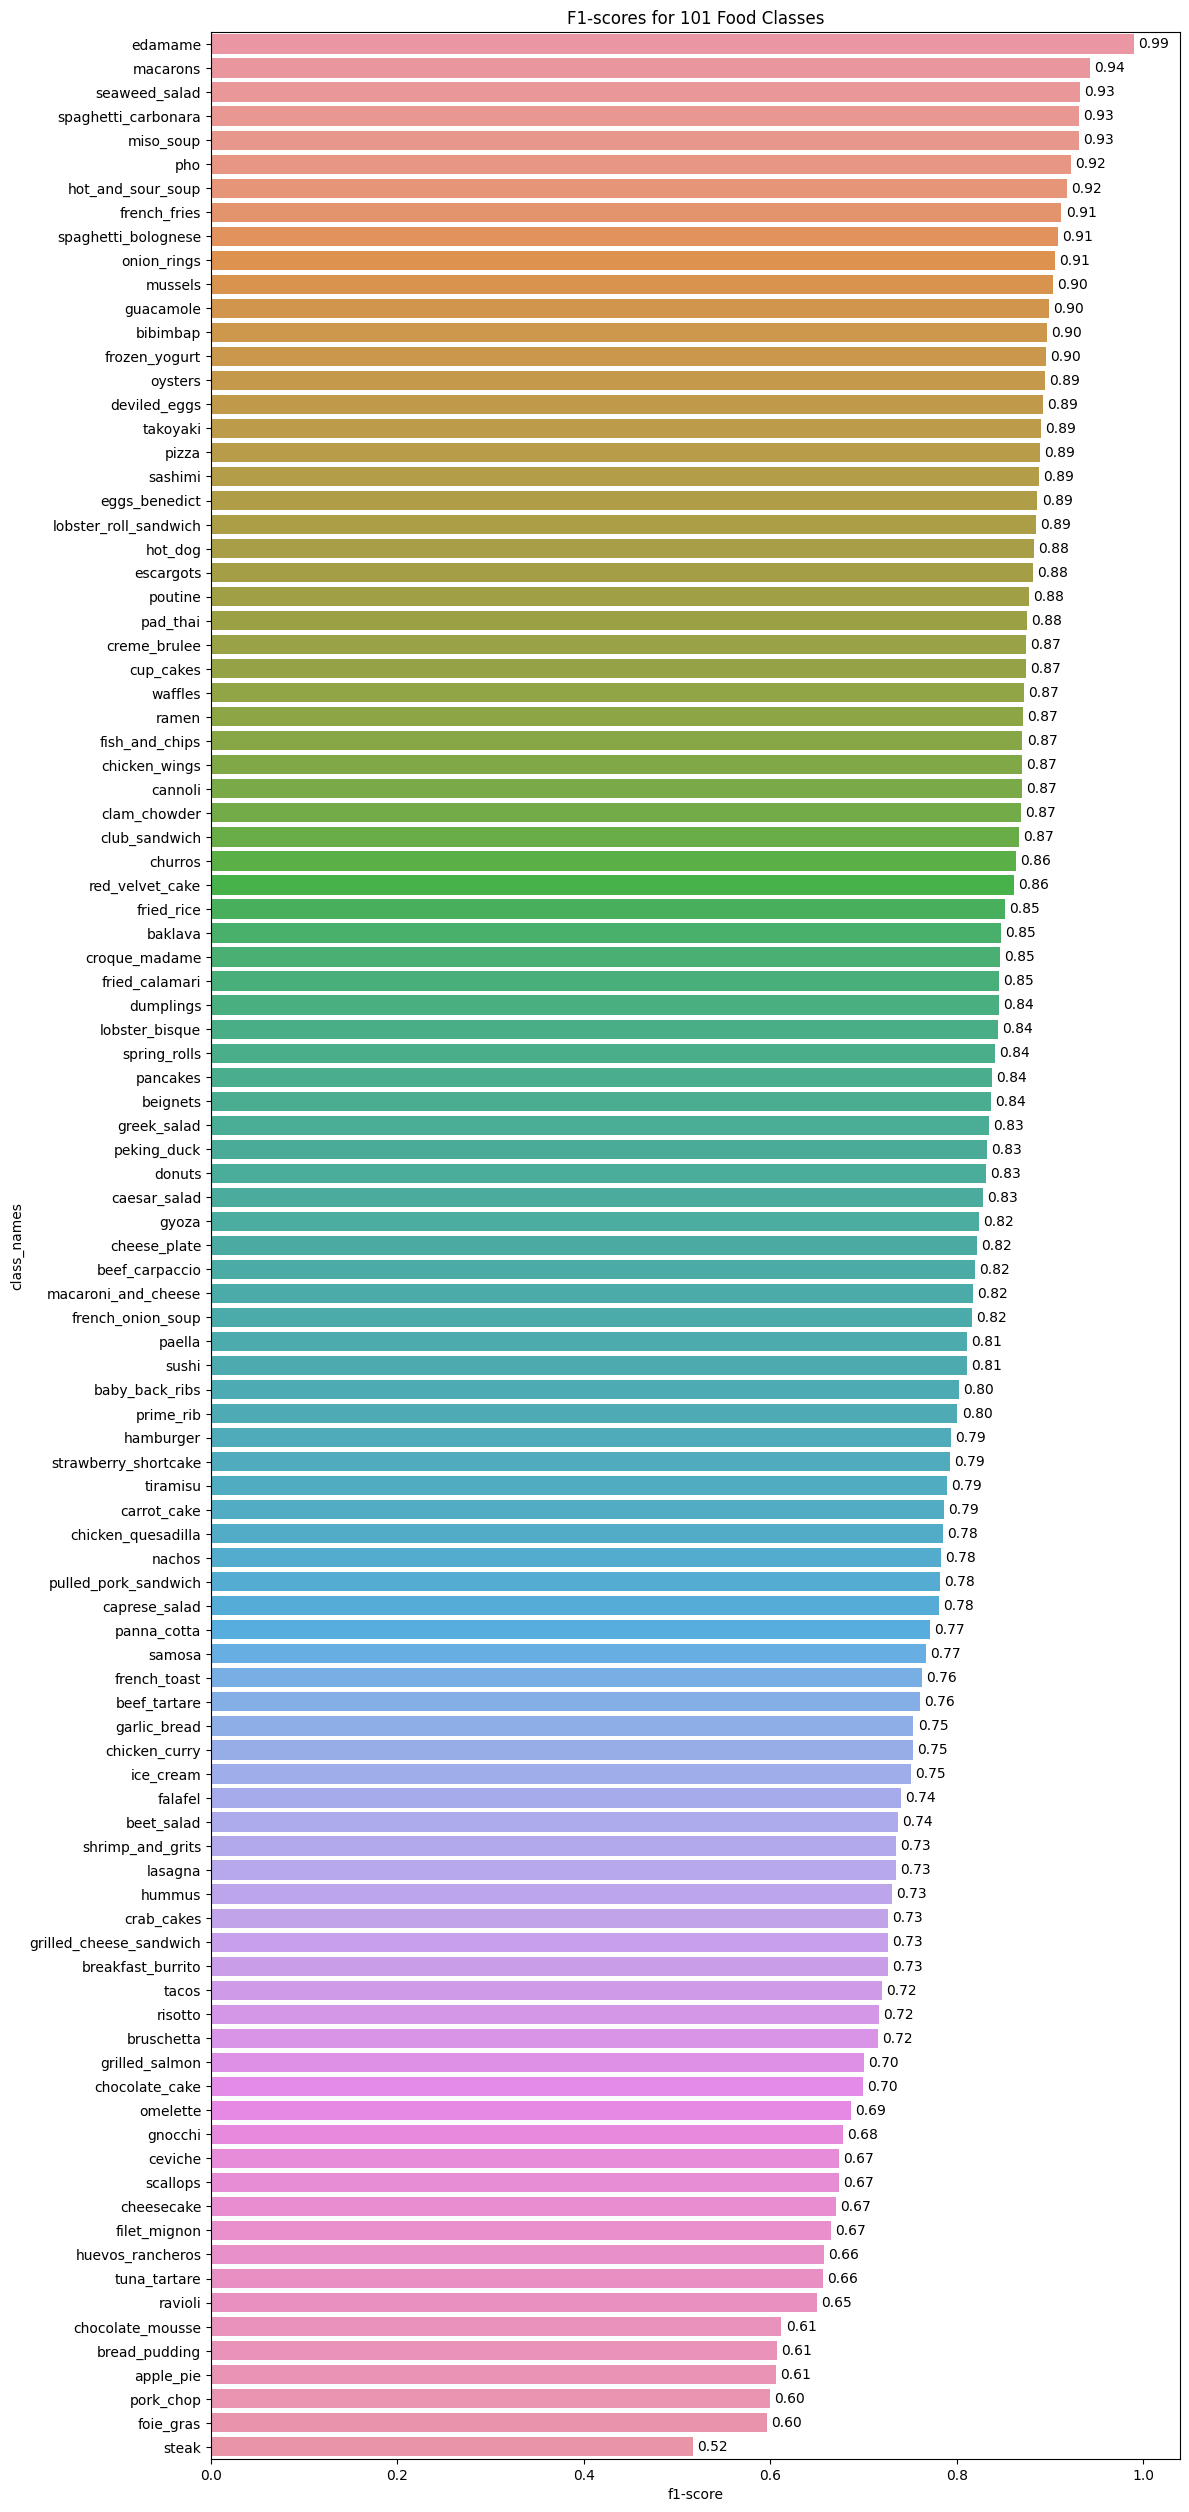

In [78]:
# Plotting barplot to visually compare f1 scores

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,25))
sns.barplot(f1_scores, x = 'f1-score', y = 'class_names')
plt.tight_layout()
plt.title('F1-scores for 101 Food Classes')

for index, row in f1_scores.iterrows():
    plt.annotate(f"{float(row['f1-score']):.2f}",   # Annotation text
                 xy=(row['f1-score'], index),       # Position of the annotation
                 xytext=(3, 0),                     # Offset from the bar
                 textcoords="offset points",
                 va='center')

## Making predictions on random images and visualising them

In [125]:
# Shuffling the data so that we can get random images
shuffled_data = test_data.unbatch().shuffle(buffer_size=1000)

1/1 [==============================] - 0s 25ms/step


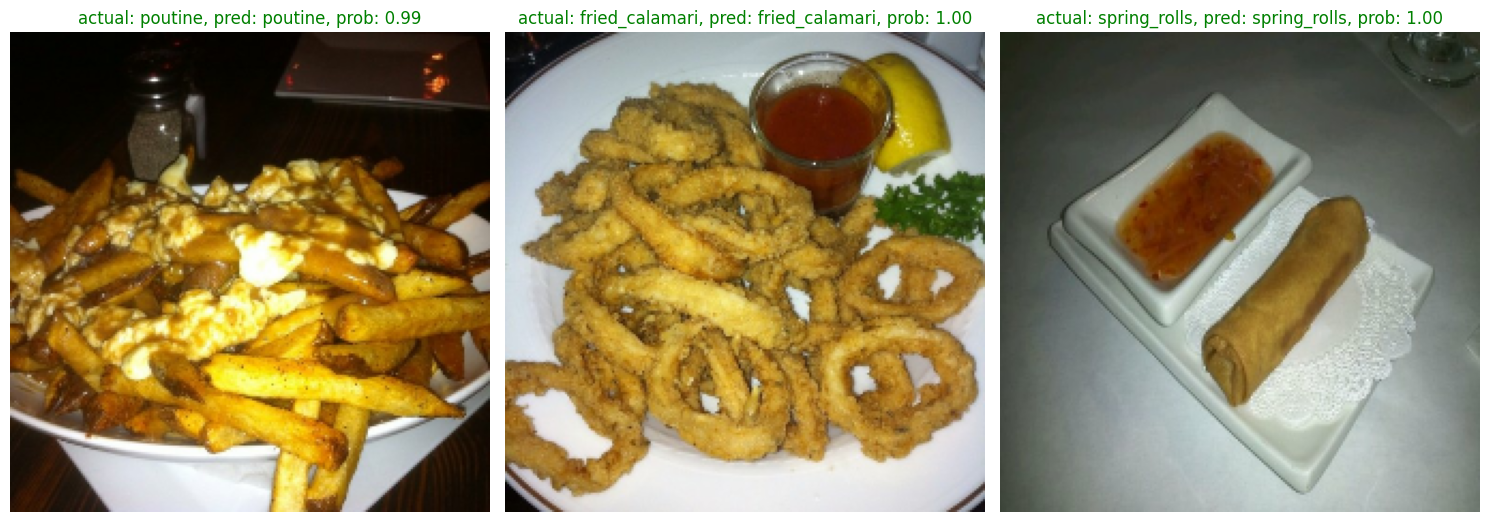

In [190]:
# Predicting and plotting 3 random images

plt.figure(figsize=(15,10))

for i, (image, label) in enumerate(shuffled_data.take(3)):

      # Preprocessing the image for prediction
      img = tf.image.resize(image, [224,224])
      img_expanded = tf.expand_dims(img, axis=0)
      pred_prob = loaded_model.predict(img_expanded)
      pred_class = class_names[pred_prob.argmax()]
      class_name = class_names[label]

      # Plot the image(s)
      plt.subplot(1,3,i+1)
      plt.imshow(img/255.)
      if class_name == pred_class: # if predicted class matches truth class, make text green
        title_color = 'g'
      else:
        title_color = 'r'

      plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c = title_color)
      plt.axis(False);

      plt.tight_layout()

## Finding the most wrong predictions

In [191]:
# Creating a DataFrame of different parameters for each of our test images

pred_df = pd.DataFrame({'true_label': y_labels,
                        'pred_label': pred_classes,
                        'pred_conf': pred_probs.max(axis=1),
                        'true_class_name': [class_names[i] for i in y_labels],
                        'pred_class_name': [class_names[i] for i in pred_classes]})

pred_df.head()

true_label  pred_label  pred_conf      true_class_name      pred_class_name
0          29          29   0.981023            cup_cakes            cup_cakes
1          81          81   0.998749                ramen                ramen
2          91          91   0.999990  spaghetti_carbonara  spaghetti_carbonara
3          53          53   0.999969            hamburger            hamburger
4          97          97   0.999943             takoyaki             takoyaki

In [195]:
# Finding which predictions are wrong
pred_df['correct'] = pred_df['true_label'] == pred_df['pred_label']
pred_df.head()

true_label  pred_label  pred_conf      true_class_name  \
0          29          29   0.981023            cup_cakes   
1          81          81   0.998749                ramen   
2          91          91   0.999990  spaghetti_carbonara   
3          53          53   0.999969            hamburger   
4          97          97   0.999943             takoyaki   

       pred_class_name  correct  
0            cup_cakes     True  
1                ramen     True  
2  spaghetti_carbonara     True  
3            hamburger     True  
4             takoyaki     True

In [194]:
# Finding the most wrong predictions (predictions with highest pred conf but wrong class)
top_100_wrong = pred_df[pred_df['correct']==False].sort_values(by='pred_conf', ascending=False)[:100]
top_100_wrong.reset_index(inplace=True, drop = True)
top_100_wrong.head()

true_label  pred_label  pred_conf true_class_name pred_class_name  correct
0          14          29        1.0     carrot_cake       cup_cakes    False
1          46          10        1.0    garlic_bread      bruschetta    False
2          68          70        1.0     onion_rings        pad_thai    False
3          71          70        1.0          paella        pad_thai    False
4          37          21        1.0    filet_mignon  chocolate_cake    False

# Testing the model on Custom Images

--2023-09-16 12:47:10--  https://www.recipetineats.com/wp-content/uploads/2019/07/Cheffy-Garlic-Butter-Steak_9.jpg
Resolving www.recipetineats.com (www.recipetineats.com)... 192.0.66.112
Connecting to www.recipetineats.com (www.recipetineats.com)|192.0.66.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89033 (87K) [image/jpeg]
Saving to: ‘Cheffy-Garlic-Butter-Steak_9.jpg’

Cheffy-Garlic-Butte 100%[===================>]  86.95K  --.-KB/s    in 0.05s   

2023-09-16 12:47:10 (1.57 MB/s) - ‘Cheffy-Garlic-Butter-Steak_9.jpg’ saved [89033/89033]

1/1 [==============================] - 0s 50ms/step


(-0.5, 223.5, 223.5, -0.5)

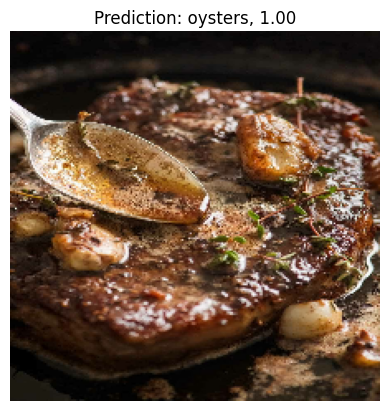

In [198]:
!wget https://www.recipetineats.com/wp-content/uploads/2019/07/Cheffy-Garlic-Butter-Steak_9.jpg
filepath = 'Cheffy-Garlic-Butter-Steak_9.jpg'

# Read the image file
img = tf.io.read_file(filepath)

# Decode image into tensor
img = tf.io.decode_image(img, channels=3)

# Resize image
img = tf.image.resize(img, [224,224])
img_expanded = tf.expand_dims(img, axis=0)

# Make predictions
pred_prob = loaded_model.predict(img_expanded)
pred_class = class_names[pred_prob.argmax()]

# Plot image and prediction
plt.imshow(img/255.)
plt.title(f"Prediction: {pred_class}, {pred_prob.max():.2f}")
plt.axis(False)